In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

In [2]:
infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()
df.set_index('id', inplace = True)

In [4]:
def evaluation_report(model, X_test, y_test): # label = list(genre_mapping.keys())
    y_pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, model.predict(X_test), average = 'macro')}")
    print(f"Accuracy Score: {accuracy_score(y_test, model.predict(X_test))}")
    plot_confusion_matrix(model, X_test, y_test, cmap='GnBu',xticks_rotation='vertical')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1),
                                                    df.genre,
                                                   random_state=9)

In [6]:
y_train.value_counts(normalize=True)

hip-hop      0.418881
alt-metal    0.240445
rock         0.209567
pop          0.131106
Name: genre, dtype: float64

**First Simple Model**

In [7]:
lr = LogisticRegression(random_state=9)
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=9)

In [8]:
lr.classes_

array(['alt-metal', 'hip-hop', 'pop', 'rock'], dtype=object)

Training
F1 Score: 0.6263683742501592
Accuracy Score: 0.7112123513034675


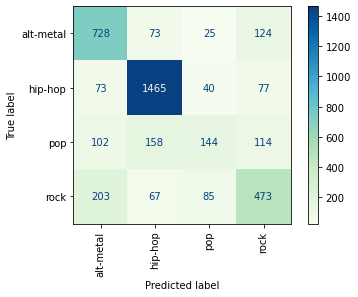

In [9]:
print('Training')
evaluation_report(lr, X_train_scaled, y_train)

Testing
F1 Score: 0.6399862672407418
Accuracy Score: 0.7129840546697038


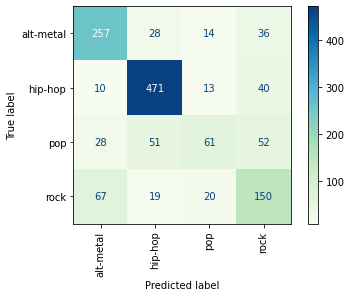

In [10]:
print('Testing')
evaluation_report(lr, X_test_scaled, y_test)

**Second Model**

In [11]:
lr2 = LogisticRegression(class_weight='balanced',random_state=9)
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
lr2.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=9)

Training
F1 Score: 0.6377769247794889
Accuracy Score: 0.6808402935965578


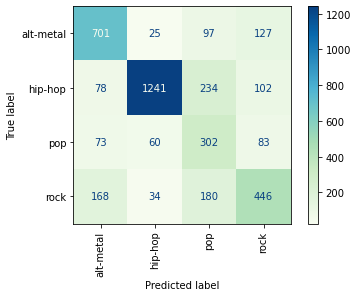

In [12]:
print('Training')
evaluation_report(lr2, X_train_scaled, y_train)

Testing
F1 Score: 0.6450526680907321
Accuracy Score: 0.6810933940774487


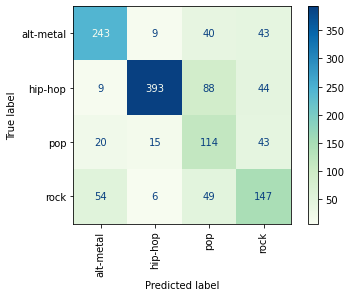

In [13]:
print('Testing')
evaluation_report(lr2, X_test_scaled, y_test)